****Capstone Project****

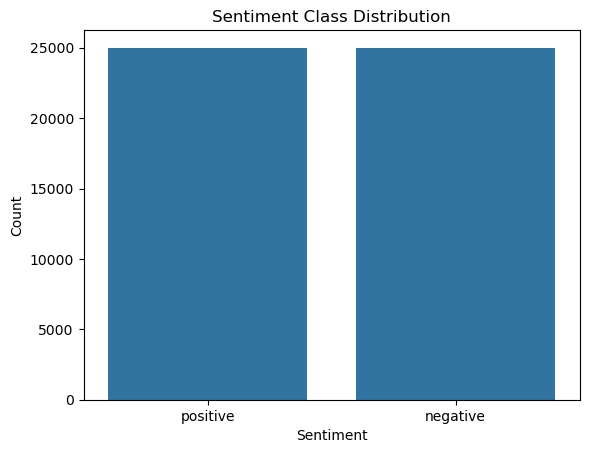

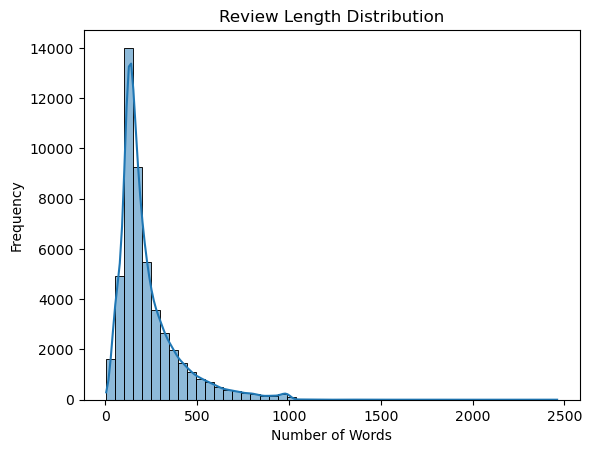

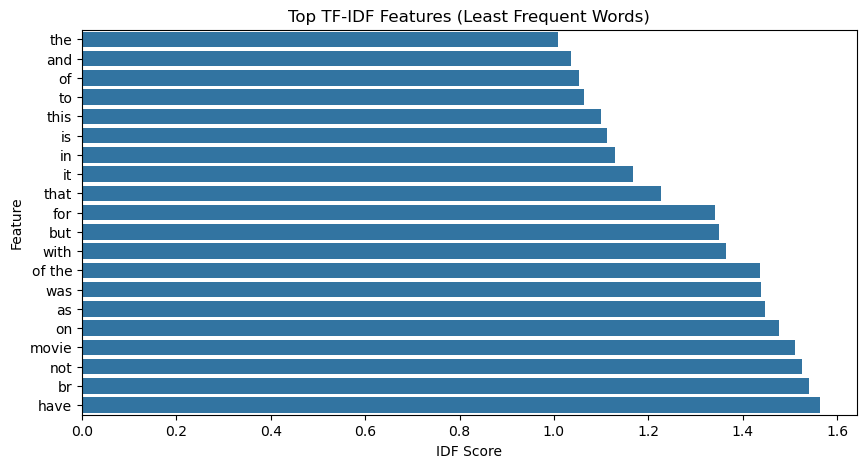


Model: Logistic Regression
Accuracy: 0.8979
Precision: 0.892483724600513
Recall: 0.9048
F1 Score: 0.8985996623299235

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5000
           1       0.89      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



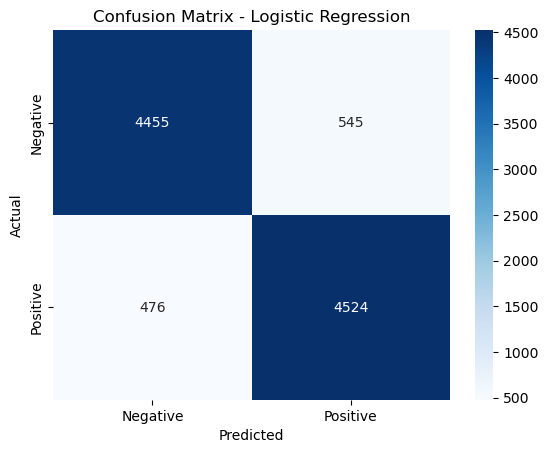


Model: Support Vector Machine
Accuracy: 0.9046
Precision: 0.899171270718232
Recall: 0.9114
F1 Score: 0.9052443384982122

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5000
           1       0.90      0.91      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



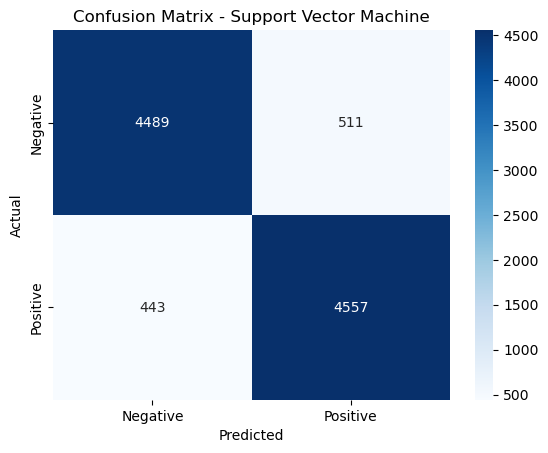

Review: I absolutely loved this movie! The story was amazing and the acting was brilliant.
Logistic Regression Prediction: Positive
SVM Prediction: Positive

Review: Worst movie ever. It was a complete waste of time.
Logistic Regression Prediction: Negative
SVM Prediction: Negative



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load the dataset
file_path = "data/imdb.csv"
df = pd.read_csv(file_path)

# Visualize class distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    return text

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)

# Convert sentiment labels to numeric
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

# Show lengths of reviews before vectorization
review_lengths = df['review'].apply(lambda x: len(x.split()))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Convert text to TF-IDF vectors with bigrams and increased feature size
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Visualize top TF-IDF features
def plot_top_tfidf_features(tfidf_vectorizer, top_n=20):
    feature_array = np.array(tfidf_vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(tfidf.idf_)
    top_features = feature_array[tfidf_sorting][:top_n]
    top_scores = tfidf.idf_[tfidf_sorting][:top_n]
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_scores, y=top_features)
    plt.title("Top TF-IDF Features (Least Frequent Words)")
    plt.xlabel("IDF Score")
    plt.ylabel("Feature")
    plt.show()

plot_top_tfidf_features(tfidf)

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Initialize models with optimized hyperparameters
log_reg = LogisticRegression(C=0.5)
svm = SVC(kernel='linear', C=0.5)

# Train Logistic Regression
log_reg.fit(X_train_tfidf, y_train)
y_pred_log = log_reg.predict(X_test_tfidf)

# Train SVM
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

# Save trained models
with open("logistic_regression.pkl", "wb") as f:
    pickle.dump(log_reg, f)

with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm, f)

# Function to evaluate models with visualization
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate both models
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_svm, "Support Vector Machine")

# Function to predict sentiment for new reviews
def predict_sentiment(new_reviews):
    # Load vectorizer and models
    with open("tfidf_vectorizer.pkl", "rb") as f:
        tfidf = pickle.load(f)
    with open("logistic_regression.pkl", "rb") as f:
        log_reg = pickle.load(f)
    with open("svm_model.pkl", "rb") as f:
        svm = pickle.load(f)

    # Preprocess new reviews
    new_reviews_cleaned = [preprocess_text(review) for review in new_reviews]
    new_reviews_tfidf = tfidf.transform(new_reviews_cleaned)

    # Predict using both models
    predictions_log = log_reg.predict(new_reviews_tfidf)
    predictions_svm = svm.predict(new_reviews_tfidf)

    # Display results
    for review, sentiment_log, sentiment_svm in zip(new_reviews, predictions_log, predictions_svm):
        print(f"Review: {review}")
        print(f"Logistic Regression Prediction: {'Positive' if sentiment_log == 1 else 'Negative'}")
        print(f"SVM Prediction: {'Positive' if sentiment_svm == 1 else 'Negative'}\n")

# Example predictions
new_reviews = [
    "I absolutely loved this movie! The story was amazing and the acting was brilliant.",
    "Worst movie ever. It was a complete waste of time."
]
predict_sentiment(new_reviews)


In [8]:
new_reviews = [
    "Delighting in razzle-dazzle over historical precision, Gladiator II rigorously entertains all the better for it.",  "Echoing its predecessor while upping the bloodsport and camp, Gladiator II is an action extravaganza that derives much of its strength and honor from Denzel Washington's scene-stealing performance.",
    "Watching Gladiator II, it is hard not to be a little suspicious about exactly what we are longing for in our Roman fantasies."
]
predict_sentiment(new_reviews)

Review: Delighting in razzle-dazzle over historical precision, Gladiator II rigorously entertains all the better for it.
Logistic Regression Prediction: Negative
SVM Prediction: Negative

Review: Echoing its predecessor while upping the bloodsport and camp, Gladiator II is an action extravaganza that derives much of its strength and honor from Denzel Washington's scene-stealing performance.
Logistic Regression Prediction: Positive
SVM Prediction: Positive

Review: Watching Gladiator II, it is hard not to be a little suspicious about exactly what we are longing for in our Roman fantasies.
Logistic Regression Prediction: Positive
SVM Prediction: Positive

